In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Lambda, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import os

# specify GPU device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# freeze existing trained  weights
for layer in vgg.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/DAEN690/NEW"
filenames = os.listdir(path)

df=pd.DataFrame({'filename':filenames})
df["category"] = df.apply(lambda x: x['filename'].split(' ')[0], axis=1)

train_df, validate_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df["category"])
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42, stratify=validate_df["category"])

#resetting the index
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
print(train_df.category.value_counts())
print(validate_df.category.value_counts())
print(test_df.category.value_counts())

usa      7000
India    7000
china    7000
Name: category, dtype: int64
usa      1500
India    1500
china    1500
Name: category, dtype: int64
usa      1501
India    1500
china    1500
Name: category, dtype: int64


In [ ]:
test_df

,filename,category
0,India (1057).jpg,India
1,china (3690).jpg,china
2,china (2087).jpg,china
3,India (4927).jpg,India
4,India (2124).jpg,India
...,...,...
4496,usa (9729).jpg,usa
4497,usa (804).jpg,usa
4498,usa (8650).jpg,usa
4499,India (6229).jpg,India


In [ ]:
train_datagen = ImageDataGenerator( rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip = True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

train_set = train_datagen.flow_from_dataframe(train_df,path,x_col='filename',y_col='category',
                                              target_size=(224, 224),class_mode='categorical',batch_size=32)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_set = validation_datagen.flow_from_dataframe(validate_df,path,x_col='filename',
                                                        y_col='category',target_size=(224, 224),
                                                        class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_dataframe(test_df,path,x_col='filename',
                                            y_col='category',target_size=(224, 224),
                                            class_mode='categorical',batch_size=32, shuffle=False)

Found 21000 validated image filenames belonging to 3 classes.
Found 4500 validated image filenames belonging to 3 classes.
Found 4501 validated image filenames belonging to 3 classes.


In [ ]:
# Add dropout layers

# x = Dense(1024, activation='relu')(vgg.output)
# x = Dense(512, activation='relu')(x)
x = Flatten()(vgg.output)

prediction = Dense(len(train_df.category.value_counts()), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

r = model.fit(train_set,
              validation_data=validation_set,
              epochs=30,
              steps_per_epoch=len(train_set),
              validation_steps=len(validation_set),
              callbacks=[callback])

Epoch 1/30
657/657 [==============================] - 13415s 20s/step - loss: 0.9106 - accuracy: 0.5681 - val_loss: 0.7981 - val_accuracy: 0.6500
Epoch 2/30
657/657 [==============================] - 752s 1s/step - loss: 0.7702 - accuracy: 0.6610 - val_loss: 0.7165 - val_accuracy: 0.6942
Epoch 3/30
657/657 [==============================] - 742s 1s/step - loss: 0.7260 - accuracy: 0.6776 - val_loss: 0.7006 - val_accuracy: 0.7013
Epoch 4/30
657/657 [==============================] - 726s 1s/step - loss: 0.7230 - accuracy: 0.6878 - val_loss: 0.6845 - val_accuracy: 0.7096
Epoch 5/30
657/657 [==============================] - 729s 1s/step - loss: 0.7101 - accuracy: 0.6938 - val_loss: 0.6940 - val_accuracy: 0.7069
Epoch 6/30
657/657 [==============================] - 714s 1s/step - loss: 0.6986 - accuracy: 0.7025 - val_loss: 0.6722 - val_accuracy: 0.7153
Epoch 7/30
657/657 [==============================] - 712s 1s/step - loss: 0.6856 - accuracy: 0.7073 - val_loss: 0.6776 - val_accuracy: 0.7

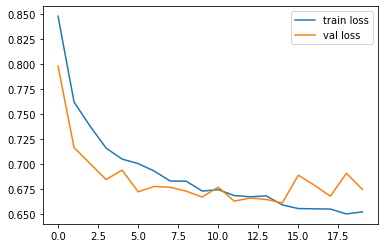

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DAEN690/VGG_ValLoss_3.png')
plt.show()

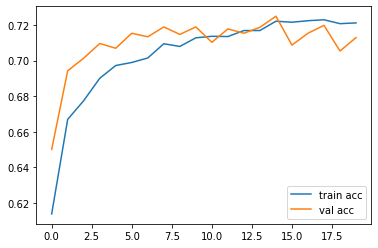

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DAEN690/VGG_ValACC_3.png')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/DAEN690/VGG16_3/VGG16_3.h5')

In [ ]:
train_set.class_indices.items()

dict_items([('India', 0), ('china', 1), ('usa', 2)])

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/DAEN690/VGG16_3/VGG16_3.h5')
test_set.reset()
pred = model.predict(test_set)
test_df["pred"] = np.argmax(pred, axis=1)
test_df["pred"] = test_df["pred"].replace({0:'India',1:'china',2:'usa'})
test_df.tail()

,filename,category,pred
4496,usa (9729).jpg,usa,usa
4497,usa (804).jpg,usa,usa
4498,usa (8650).jpg,usa,china
4499,India (6229).jpg,India,India
4500,china (3659).jpg,china,china


In [ ]:
test_df.to_csv("/content/drive/MyDrive/Colab Notebooks/DAEN690/VGG16_3/test_set.csv")

In [ ]:
model.evaluate(test_set, verbose=2)

141/141 - 2347s - loss: 0.6206 - accuracy: 0.7416


[0.6206353306770325, 0.74161297082901]

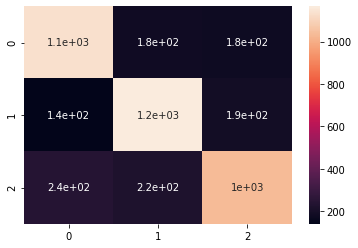

In [ ]:
cm = confusion_matrix(test_df['category'], test_df['pred'])
sns.heatmap(cm, annot=True)

In [ ]:
target_names = [ 'india', 'china', 'usa']
classification_report(test_df['category'], test_df['pred'], target_names= target_names)

'              precision    recall  f1-score   support\n\n       india       0.75      0.76      0.75      1500\n       china       0.74      0.78      0.76      1500\n         usa       0.73      0.69      0.71      1501\n\n    accuracy                           0.74      4501\n   macro avg       0.74      0.74      0.74      4501\nweighted avg       0.74      0.74      0.74      4501\n'

In [ ]:
#               precision    recall  f1-score   support

#        india       0.75      0.76      0.75      1500
#        china       0.74      0.78      0.76      1500
#          usa       0.73      0.69      0.71      1501

#     accuracy                           0.74      4501
#    macro avg       0.74      0.74      0.74      4501
# weighted avg       0.74      0.74      0.74      4501

In [ ]:
from keras.preprocessing import image

sample_test = test_df.sample(n=35).reset_index(drop=True)
plt.figure(figsize=(20, 20))
for index, row in sample_test.iterrows():
    filename = row['filename']
    pred = row['pred']
    img = image.load_img(path + "/" + filename, target_size=(224,224))
    plt.subplot(5, 7, index+1)
    plt.imshow(img)
    plt.xlabel(filename.split(' ')[0] + '(' + "{}".format(pred) + ')' )
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Found 1 validated image filenames belonging to 1 classes.


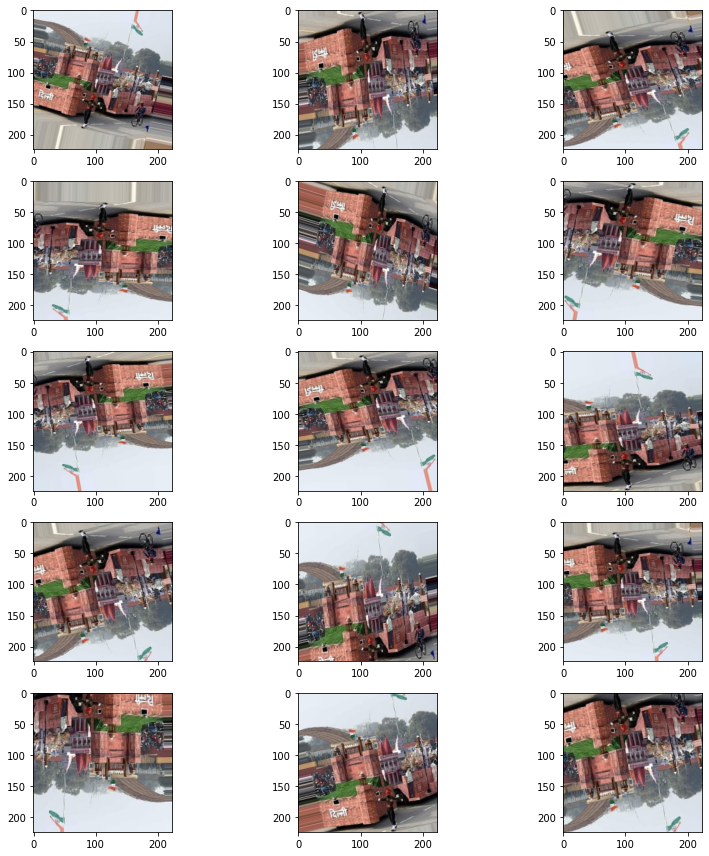

In [ ]:
# Image Augmentation
example_df = train_df.sample(n=1).reset_index(drop=True)
example_set = train_datagen.flow_from_dataframe(
    example_df, 
    path,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_set:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()